# Modèle on-off

# Epitope NP118

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, least_squares
import matplotlib.ticker as ticker


# Epitope NP118

## Méthode 1

In [2]:
# Paramètre fixé
delta = 1e-5

#Définition des modèles A(t) et M(t)
def model_A(t, T_on, T_off, alpha, r, rho):
    if t < T_on:
        return 0
    elif t <= T_off:
        # A(T_on)=60
        return 60 * np.exp(rho * (t - T_on))
    else:
        return 60 * np.exp(rho * (T_off - T_on)) * np.exp(-(r + alpha) * (t - T_off))

def model_M(t, T_on, T_off, alpha, r, rho):
    if t < T_off:
        return 0
    else:
        A_Toff = 60 * np.exp(rho * (T_off - T_on))
        return r / (r + alpha - delta) * A_Toff * (np.exp(-delta * (t - T_off)) - np.exp(-(r + alpha) * (t - T_off)))

# CELLULES NAIVES (N)
def N(t, T_on, T_off):
    if t < T_on:
        return 60
    else:
        return 0

In [3]:
# fonction de simulation complète : renvoie la somme (A+M+N), A(t) et M(t)
def simulate(params, time):
    T_on, T_off, alpha, r, rho = params
    A_vals = np.array([model_A(t, T_on, T_off, alpha, r, rho) for t in time])
    M_vals = np.array([model_M(t, T_on, T_off, alpha, r, rho) for t in time])
    N_vals = np.array([N(t, T_on, T_off) for t in time])
    pred = A_vals + M_vals + N_vals
    return pred, A_vals, M_vals

# données
df = pd.read_csv('Fig2NP118_Mesure.csv', header=None)
time118 = df[0].values
data118 = df[1].values

time118 = np.insert(time118, 0, 0.0)
data118 = np.insert(data118, 0, 60.0)

In [4]:
# --- Définition de la fonction objectif pour l'optimisation globale ---
def objective(params):
    pred, _, _ = simulate(params, time118)
    # Pénalité pour forcer A(T_on)=60 :
    # On fixe t = T_on et on passe T_on = params[0] comme argument
    penalty = np.abs(model_A(params[0], params[0], params[1], params[2], params[3], params[4]) - 60)
    # Erreur : somme des carrés des différences en logarithme (pour mieux gérer les échelles)
    error = np.sum((np.log(1 + pred) - np.log(1 + data118))**2)
    penalty_weight = 1e6
    return error + penalty_weight * penalty
# Optimisation globale avec differential_evolution 
bounds = [(0.1, 5),    # T_on
          (5, 20),     # T_off
          (0, 10),     # alpha
          (0.0001, 1), # r
          (0, 10)]     # rho

result_de = differential_evolution(objective, bounds)
best_params_de = result_de.x
print("Paramètres optimisés (globalement) :", best_params_de)
print("A(T_on) =", model_A(best_params_de[0], best_params_de[0], best_params_de[1],
                              best_params_de[2], best_params_de[3], best_params_de[4]))

Paramètres optimisés (globalement) : [1.21346727 5.91295846 0.50334845 0.01046619 2.82143561]
A(T_on) = 60.0


In [5]:
# affinement local avec least_squares 
def erreur(params, time, data):
    pred, _, _ = simulate(params, time)
    return np.log(1 + pred) - np.log(1 + data)

result_local = least_squares(erreur, best_params_de, args=(time118, data118), method='lm')
best_params = result_local.x
print("Paramètres optimisés (après affinement) :", best_params)
print("A(T_on) =", model_A(best_params[0], best_params[0], best_params[1],
                              best_params[2], best_params[3], best_params[4]))

# --- Calcul de l'erreur SSR ---
pred_optimized, _, _ = simulate(best_params, time118)
ssr = np.sum((np.log(1 + data118) - np.log(1 + pred_optimized))**2)
print("Erreur SSR =", ssr)

Paramètres optimisés (après affinement) : [1.21344022 5.91293368 0.50333138 0.01046621 2.82142389]
A(T_on) = 60.0
Erreur SSR = 0.7996164360985253


In [6]:
# --- Estimation des intervalles de confiance par bootstrap ---
n_boot = 500
param_samples = []
resid = np.log(1 + data118) - np.log(1 + pred_optimized)

for i in range(n_boot):
    # On échantillonne les résidus avec remplacement
    noise = np.random.choice(resid, size=len(resid), replace=True)
    new_log = np.log(1 + pred_optimized) + noise
    y_boot = np.exp(new_log) - 1
    result_boot = least_squares(erreur, best_params, args=(time118, y_boot), method='lm')
    param_samples.append(result_boot.x)
    
param_samples = np.array(param_samples)

# Calcul des intervalles de confiance à 95% pour chaque paramètre
param_names = ['T_on', 'T_off', 'alpha', 'r', 'rho']
for i, name in enumerate(param_names):
    low, high = np.percentile(param_samples[:, i], [2.5, 97.5])
    print(f"{name} = {best_params[i]:.4f} (IC 95%: [{low:.4f}, {high:.4f}])")

T_on = 1.2134 (IC 95%: [0.9400, 1.4606])
T_off = 5.9129 (IC 95%: [5.7169, 6.1481])
alpha = 0.5033 (IC 95%: [0.3905, 0.6884])
r = 0.0105 (IC 95%: [0.0067, 0.0156])
rho = 2.8214 (IC 95%: [2.5728, 3.0731])


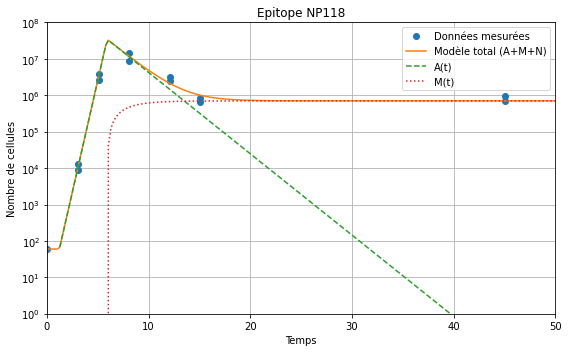

In [7]:

# Simulation avec les paramètres optimisés pour visualisation 
t = np.linspace(0, 50, 200)
pred, A_vals, M_vals = simulate(best_params, t)

# Visualisation
T_on, _, _, _, _ = best_params
mask_post = t >= T_on
plt.figure(figsize=(8, 5))
plt.plot(time118, data118, 'o', label='Données mesurées')
plt.plot(t, pred, '-', label='Modèle total (A+M+N)')
plt.plot(t[mask_post], A_vals[mask_post], '--', label='A(t)')
plt.plot(t, M_vals, ':', label='M(t)')

plt.xlabel('Temps')
plt.ylabel('Nombre de cellules')
plt.yscale('log', base=10)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
plt.ylim(1e0, 1e8)
plt.xlim(0, 50)
plt.legend()
plt.title('Epitope NP118')
plt.grid(True)
plt.tight_layout()
plt.show()


## Méthode 2

Paramètres optimisés (globalement) : [1.21343987 5.91293084 0.50332792 0.01046616 2.8214236 ]
A(T_on) = 60.0
Paramètres optimisés (après affinement) : [1.21344021 5.9129309  0.50332818 0.01046617 2.82142389]
A(T_on) = 60.0
Erreur SSR = 0.7996164358865041
T_on = 1.2134 (IC 95%: [0.9545, 1.4682])
T_off = 5.9129 (IC 95%: [5.7055, 6.1638])
alpha = 0.5033 (IC 95%: [0.3987, 0.7030])
r = 0.0105 (IC 95%: [0.0067, 0.0165])
rho = 2.8214 (IC 95%: [2.5803, 3.0807])


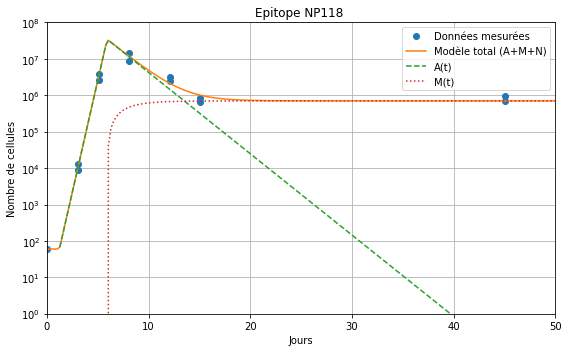

In [10]:
# --- Chargement des données ---
df = pd.read_csv('Fig2NP118_Mesure.csv', header=None)
time28 = df[0].values
data28 = df[1].values

# Ajout d'un point initial à t=0 (avec N(0)=60)
time28 = np.insert(time28, 0, 0.0)
data28 = np.insert(data28, 0, 60.0)

# --- Définition de la fonction objectif pour l'optimisation globale ---
def objective(params):
    pred, _, _ = simulate(params, time28)
    # Pénalité pour forcer A(T_on)=60 :
    # On fixe t = T_on et on passe T_on = params[0] comme argument
    penalty = np.abs(model_A(params[0], params[0], params[1], params[2], params[3], params[4]) - 60)
    # Erreur : somme des carrés des différences en logarithme (pour mieux gérer les échelles)
    error = np.sum((np.log(1 + pred) - np.log(1 + data28))**2)
    penalty_weight = 1e6
    return error + penalty_weight * penalty

# --- Optimisation globale avec differential_evolution ---
bounds = [(0.1, 2),    # T_on
          (5, 20),     # T_off
          (0, 10),     # alpha
          (0.0001, 1), # r
          (0, 10)]     # rho

result_de = differential_evolution(objective, bounds)
best_params_de = result_de.x
print("Paramètres optimisés (globalement) :", best_params_de)
print("A(T_on) =", model_A(best_params_de[0], best_params_de[0], best_params_de[1],
                              best_params_de[2], best_params_de[3], best_params_de[4]))

# --- Affinement local avec least_squares ---
def erreur(params, time, data):
    pred, _, _ = simulate(params, time)
    return np.log(1 + pred) - np.log(1 + data)

result_local = least_squares(erreur, best_params_de, args=(time28, data28), method='lm')
best_params = result_local.x
print("Paramètres optimisés (après affinement) :", best_params)
print("A(T_on) =", model_A(best_params[0], best_params[0], best_params[1],
                              best_params[2], best_params[3], best_params[4]))

# Calcul de l'erreur SSR 
pred_optimized, _, _ = simulate(best_params, time28)
ssr = np.sum((np.log(1 + data28) - np.log(1 + pred_optimized))**2)
print("Erreur SSR =", ssr)

# Estimation des intervalles de confiance par bootstrap 
n_boot = 500
param_samples = []
resid = np.log(1 + data28) - np.log(1 + pred_optimized)

for i in range(n_boot):
    # On échantillonne les résidus avec remplacement
    noise = np.random.choice(resid, size=len(resid), replace=True)
    new_log = np.log(1 + pred_optimized) + noise
    y_boot = np.exp(new_log) - 1
    result_boot = least_squares(erreur, best_params, args=(time28, y_boot), method='lm')
    param_samples.append(result_boot.x)
    
param_samples = np.array(param_samples)

# Calcul des intervalles de confiance à 95% pour chaque paramètre
param_names = ['T_on', 'T_off', 'alpha', 'r', 'rho']
for i, name in enumerate(param_names):
    low, high = np.percentile(param_samples[:, i], [2.5, 97.5])
    print(f"{name} = {best_params[i]:.4f} (IC 95%: [{low:.4f}, {high:.4f}])")


t = np.linspace(0, 50, 200)
pred, A_vals, M_vals = simulate(best_params, t)


T_on, _, _, _, _ = best_params
mask_post = t >= T_on
plt.figure(figsize=(8, 5))
plt.plot(time28, data28, 'o', label='Données mesurées')
plt.plot(t, pred, '-', label='Modèle total (A+M+N)')
plt.plot(t[mask_post], A_vals[mask_post], '--', label='A(t)')
plt.plot(t, M_vals, ':', label='M(t)')

plt.xlabel('Jours')
plt.ylabel('Nombre de cellules')
plt.yscale('log', base=10)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
plt.ylim(1e0, 1e8)
plt.xlim(0, 50)
plt.legend()
plt.title('Epitope NP118 ')
plt.grid(True)
plt.tight_layout()
plt.show()


# Epitope GP283

Paramètres optimisés (globalement) : [1.6815708  5.68804316 0.36950612 0.01087257 2.59878361]
A(T_on) = 60.0
Paramètres optimisés (après affinement) : [1.68157134 5.68804304 0.36950648 0.01087251 2.59878472]
A(T_on) = 60.0
Erreur SSR = 4.933147328384958


<ipython-input-8-226178db6662>:37: RuntimeWarning: invalid value encountered in log
  return np.log(1 + pred) - np.log(1 + data)


T_on = 1.6816 (IC 95%: [1.1251, 2.0365])
T_off = 5.6880 (IC 95%: [5.1841, 6.3124])
alpha = 0.3695 (IC 95%: [0.1652, 0.8313])
r = 0.0109 (IC 95%: [0.0041, 0.0274])
rho = 2.5988 (IC 95%: [2.1925, 3.0700])


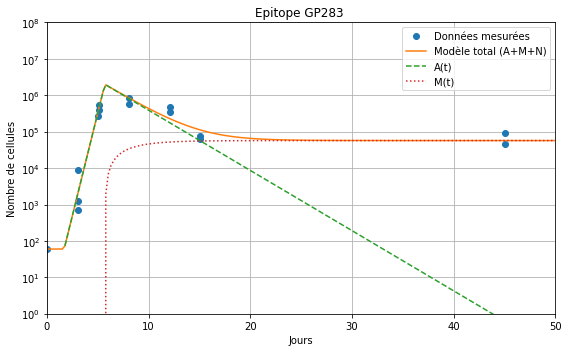

In [8]:
#  données de GP283
df = pd.read_csv('Fig2GP283_Mesure.csv', header=None)
time283 = df[0].values
data283 = df[1].values


time283 = np.insert(time283, 0, 0.0)
data283 = np.insert(data283, 0, 60.0)

# Définition de la fonction objectif pour l'optimisation globale 
def objective(params):
    pred, _, _ = simulate(params, time283)
    
    # On fixe t = T_on et on passe T_on = params[0] comme argument
    penalty = np.abs(model_A(params[0], params[0], params[1], params[2], params[3], params[4]) - 60)
    # Erreur : somme des carrés des différences en logarithme (pour mieux gérer les échelles)
    error = np.sum((np.log(1 + pred) - np.log(1 + data283))**2)
    penalty_weight = 1e6
    return error + penalty_weight * penalty

#Optimisation globale avec differential_evolution
bounds = [(0.1, 2),    # T_on
          (5, 20),     # T_off
          (0, 10),     # alpha
          (0.0001, 1), # r
          (0, 10)]     # rho

result_de = differential_evolution(objective, bounds)
best_params_de = result_de.x
print("Paramètres optimisés (globalement) :", best_params_de)
print("A(T_on) =", model_A(best_params_de[0], best_params_de[0], best_params_de[1],
                              best_params_de[2], best_params_de[3], best_params_de[4]))


def erreur(params, time, data):
    pred, _, _ = simulate(params, time)
    return np.log(1 + pred) - np.log(1 + data)

result_local = least_squares(erreur, best_params_de, args=(time283, data283), method='lm')
best_params = result_local.x
print("Paramètres optimisés (après affinement) :", best_params)
print("A(T_on) =", model_A(best_params[0], best_params[0], best_params[1],
                              best_params[2], best_params[3], best_params[4]))

#  Calcul de l'erreur SSR 
pred_optimized, _, _ = simulate(best_params, time283)
ssr = np.sum((np.log(1 + data283) - np.log(1 + pred_optimized))**2)
print("Erreur SSR =", ssr)

#  Estimation des intervalles de confiance par bootstrap 
n_boot = 500
param_samples = []
resid = np.log(1 + data283) - np.log(1 + pred_optimized)

for i in range(n_boot):
    # On échantillonne les résidus avec remplacement
    noise = np.random.choice(resid, size=len(resid), replace=True)
    new_log = np.log(1 + pred_optimized) + noise
    y_boot = np.exp(new_log) - 1
    result_boot = least_squares(erreur, best_params, args=(time283, y_boot), method='lm')
    param_samples.append(result_boot.x)
    
param_samples = np.array(param_samples)

# Calcul des intervalles de confiance à 95% pour chaque paramètre
param_names = ['T_on', 'T_off', 'alpha', 'r', 'rho']
for i, name in enumerate(param_names):
    low, high = np.percentile(param_samples[:, i], [2.5, 97.5])
    print(f"{name} = {best_params[i]:.4f} (IC 95%: [{low:.4f}, {high:.4f}])")

# --- Simulation avec les paramètres optimisés pour visualisation ---
t = np.linspace(0, 50, 200)
pred, A_vals, M_vals = simulate(best_params, t)

# --- Visualisation ---
T_on, _, _, _, _ = best_params
mask_post = t >= T_on
plt.figure(figsize=(8, 5))
plt.plot(time283, data283, 'o', label='Données mesurées')
plt.plot(t, pred, '-', label='Modèle total (A+M+N)')
plt.plot(t[mask_post], A_vals[mask_post], '--', label='A(t)')
plt.plot(t, M_vals, ':', label='M(t)')

plt.xlabel('Jours')
plt.ylabel('Nombre de cellules')
plt.yscale('log', base=10)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
plt.ylim(1e0, 1e8)
plt.xlim(0, 50)
plt.legend()
plt.title('Epitope GP283 ')
plt.grid(True)
plt.tight_layout()
plt.show()
